<a href="https://colab.research.google.com/github/DaniloJ97/spam_klasifikator/blob/main/Spam_classifier_last_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import string
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics import precision_score, recall_score, confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, f1_score, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danilojanjusevic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
sms = pd.read_csv('spam.csv',encoding='latin-1')

In [ ]:
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
sms = sms.drop(sms[to_drop], axis=1)

In [ ]:
sms

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
sms.columns = ['class','message']
sms['class'] = sms['class'].apply(lambda x: 1 if (x=='ham') else 0)

In [ ]:
sms.groupby('class').describe()

message                                                               
        count unique                                                top freq
class                                                                       
0         747    653  Please call our customer service representativ...    4
1        4825   4516                             Sorry, I'll call later   30

In [ ]:
sms.groupby('class').describe().iloc[0]['message'].top

'Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed å£1000 cash or å£5000 prize!'

In [ ]:
sms_grouped = sms.groupby('class').agg('count').reset_index()

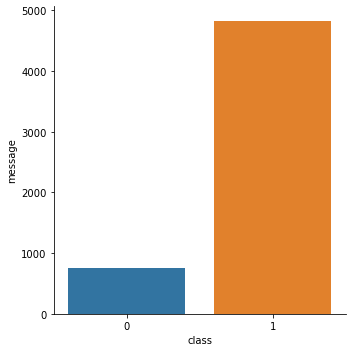

In [ ]:
sns.catplot(x='class',y='message',kind='bar',data=sms_grouped)

In [ ]:
sms['message_length'] = sms['message'].apply(lambda x: len(x))

In [ ]:
sms.describe()

,class,message_length
count,5572.000000,5572.000000
mean,0.865937,80.118808
std,0.340751,59.690841
min,0.000000,2.000000
25%,1.000000,36.000000
50%,1.000000,61.000000
75%,1.000000,121.000000
max,1.000000,910.000000


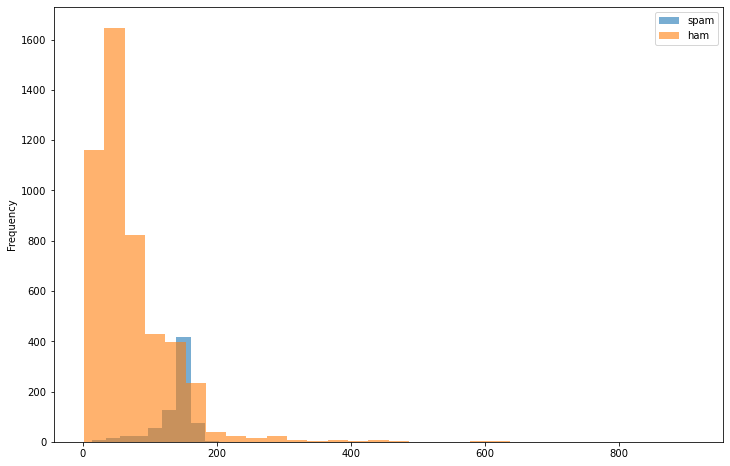

In [ ]:
plt.figure(figsize=(12, 8))
sms[sms['class']==0].message_length.plot(kind='hist',label='spam',alpha=0.6)
sms[sms['class']==1].message_length.plot(kind='hist',label='ham',bins=30,alpha=0.6)
plt.legend()

In [ ]:
sms_ham = sms[sms['class']==1]
sms_spam = sms[sms['class']==0]

In [ ]:
len(sms_spam[sms_spam.message.str.contains('http')])

21

In [ ]:
len(sms_ham[sms_ham.message.str.contains('http')])

0

In [ ]:
len(sms_spam[sms_spam.message.str.contains(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',regex=True)])

6

In [ ]:
len(sms_ham[sms_ham.message.str.contains(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',regex=True)])

1

In [ ]:
len(sms_spam[sms_spam.message.str.contains(r"[-+]?(?:\d*\.\d+|\d+)",regex=True)])

708

In [ ]:
sms_spam[sms_spam.message.str.contains(r"[-+]?(?:\d*\.\d+|\d+)",regex=True)]

,class,message,message_length
2,0,Free entry in 2 a wkly comp to win FA Cup fina...,155
5,0,FreeMsg Hey there darling it's been 3 week's n...,148
8,0,WINNER!! As a valued network customer you have...,158
9,0,Had your mobile 11 months or more? U R entitle...,154
11,0,"SIX chances to win CASH! From 100 to 20,000 po...",136
...,...,...,...
5537,0,Want explicit SEX in 30 secs? Ring 02073162414...,90
5540,0,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,160
5547,0,Had your contract mobile 11 Mnths? Latest Moto...,160
5566,0,REMINDER FROM O2: To get 2.50 pounds free call...,147


In [ ]:
len(sms_ham[sms_ham.message.str.contains(r"[-+]?(?:\d*\.\d+|\d+)",regex=True)])

748

In [ ]:
len(sms_spam[sms_spam.message.str.contains("£",regex=True)])

253

In [ ]:
len(sms_ham[sms_ham.message.str.contains("£",regex=True)])

4

In [ ]:
len(sms_spam[sms_spam.message.str.contains("\$",regex=True)])

4

In [ ]:
sms_ham[sms_ham.message.str.contains("\$",regex=True)]

,class,message,message_length
60,1,Your gonna have to pick up a $1 burger for you...,108
177,1,Turns out my friends are staying for the whole...,146
837,1,"Sir, I have been late in paying rent for the p...",372
1289,1,Hey...Great deal...Farm tour 9am to 5pm $95/pa...,70
1618,1,The 2 oz guy is being kinda flaky but one frie...,115
1765,1,Hi this is yijue... It's regarding the 3230 te...,121
2278,1,Hmm...Bad news...Hype park plaza $700 studio t...,78
2379,1,"Good evening Sir, hope you are having a nice d...",482
2592,1,My friend just got here and says he's upping h...,117
2618,1,Hey pple...$700 or $900 for 5 nights...Excelle...,81


In [ ]:
len(sms_spam[sms_spam.message.str.contains(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',regex=True)])

6

In [ ]:
def replace_http_url(x):
    words = x.replace('https','http')
    words = x.split()
    
    words = [word if(not word.startswith('http')) else 'httpPrepared' for word in words]
    
    return ' '.join(words)

In [ ]:
def replace_email(x):
    words = x.split()
    
    regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    
    words = [word if(not re.fullmatch(regex, word)) else "emailPrepared" for word in words]
    
    return " ".join(words)

In [ ]:
def replace_numbers(x):
    words = re.sub(r"[-+]?(?:\d*\.\d+|\d+)", " numberPrepared ", x)
    
    return words

In [ ]:
def replace_currencies(x):
    
    words = x.replace('$','currencyPrepared').replace('£','currencyPrepared').replace('€','currencyPrepared')
    
    return words

In [ ]:
def remove_punctation(x):
    rx = '[' + re.escape(string.punctuation) + ']'
    words = re.sub(rx, ' ', x)
    return words

In [ ]:
def remove_stop_words(x):
    words = x.split()
    
    words = ' '.join([word for word in words if word not in 
    stopwords.words('english')])
    return words

In [ ]:
def stem_words(x):
    words = x.split()
    
    ps = PorterStemmer()
    
    words = [ps.stem(word) for word in words]
    
    return ' '.join(words)

In [ ]:
def prepare_and_normalize_data(x):
    data = x.lower()
    data = remove_stop_words(data)
    data = replace_http_url(data)
    data = replace_email(data)
    data = replace_numbers(data)
    data = replace_currencies(data)
    data = remove_punctation(data)
    data = stem_words(data)
    
    return data
    

In [ ]:
sms['normalized_message'] = sms['message'].apply(prepare_and_normalize_data)

In [ ]:
sms

,class,message,message_length,normalized_message
0,1,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazi avail bugi n great world...
1,1,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni
2,0,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entri numberprepar wkli comp win fa cup f...
3,1,U dun say so early hor... U c already then say...,49,u dun say earli hor u c alreadi say
4,1,"Nah I don't think he goes to usf, he lives aro...",61,nah think goe usf live around though
...,...,...,...,...
5567,0,This is the 2nd time we have tried 2 contact u...,161,numberprepar nd time tri numberprepar contact ...
5568,1,Will Ì_ b going to esplanade fr home?,37,ì b go esplanad fr home
5569,1,"Pity, * was in mood for that. So...any other s...",57,piti mood that so ani suggest
5570,1,The guy did some bitching but I acted like i'd...,125,guy bitch act like i d interest buy someth els...


In [ ]:
tf = TfidfVectorizer()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sms['normalized_message'], sms['class'], test_size=0.2, random_state=1)

In [ ]:
X_train.shape

(4457,)

In [ ]:
vectors = tf.fit_transform(X_train)

In [ ]:
X_train_tfidf = vectors.toarray()

In [ ]:
X_train_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
#tfidf_transformer = TfidfTransformer()
#tfidf_transformer.fit(X_train_dtm)
#X_train_tfidf = tfidf_transformer.transform(X_train_dtm)

In [ ]:
X_train_tfidf.shape

(4457, 5711)

In [ ]:
X_test_tfidf = tf.transform(X_test)

In [ ]:
X_test_tfidf = X_test_tfidf.toarray()

In [ ]:
filename = 'GoogleNews-vectors-negative300.bin'
w2v = KeyedVectors.load_word2vec_format(filename, binary=True)

In [ ]:
def prepare_and_normalize_data_v2(x):
    data = x.lower()
    #data = remove_stop_words(data)
    data = replace_http_url(data)
    data = replace_email(data)
    data = replace_numbers(data)
    data = replace_currencies(data)
    data = remove_punctation(data)
    #data = stem_words(data)
    
    return data

In [ ]:
sms['prepared_v2'] = sms.message.apply(prepare_and_normalize_data_v2)

In [ ]:
sms['for_w2v'] = sms.prepared_v2.apply(lambda x: x.split())

In [ ]:
def words_to_vectors(words):
    sms_vect = np.zeros(300)
    
    for word in words:
        try:
            word_vect = w2v.get_vector(word)
            sms_vect = sms_vect + word_vect
        except:
            #print(traceback.print_exc())
            continue
    
    return sms_vect
    

In [ ]:
sms['sms_vect'] = sms.for_w2v.apply(words_to_vectors)

In [ ]:
sms

,class,message,message_length,normalized_message,prepared_v2,for_w2v,sms_vect
0,1,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazi avail bugi n great world...,go until jurong point crazy available only ...,"[go, until, jurong, point, crazy, available, o...","[-0.0166015625, 0.69622802734375, 0.5478515625..."
1,1,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[-0.3794097900390625, 0.4822998046875, 0.36566..."
2,0,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entri numberprepar wkli comp win fa cup f...,free entry in numberPrepared a wkly comp to ...,"[free, entry, in, numberPrepared, a, wkly, com...","[-1.4829330444335938, 0.7525634765625, -1.2535..."
3,1,U dun say so early hor... U c already then say...,49,u dun say earli hor u c alreadi say,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[-0.60357666015625, 0.19818115234375, 1.083099..."
4,1,"Nah I don't think he goes to usf, he lives aro...",61,nah think goe usf live around though,nah i don t think he goes to usf he lives aro...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[-0.113525390625, 0.688995361328125, -0.127319..."
...,...,...,...,...,...,...,...
5567,0,This is the 2nd time we have tried 2 contact u...,161,numberprepar nd time tri numberprepar contact ...,this is the numberPrepared nd time we have tr...,"[this, is, the, numberPrepared, nd, time, we, ...","[0.04071044921875, 1.381216049194336, 1.462753..."
5568,1,Will Ì_ b going to esplanade fr home?,37,ì b go esplanad fr home,will ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[-0.1829833984375, 0.566162109375, 0.714244842..."
5569,1,"Pity, * was in mood for that. So...any other s...",57,piti mood that so ani suggest,pity was in mood for that so any other s...,"[pity, was, in, mood, for, that, so, any, othe...","[0.05413818359375, 0.31451416015625, 0.5879821..."
5570,1,The guy did some bitching but I acted like i'd...,125,guy bitch act like i d interest buy someth els...,the guy did some bitching but i acted like i d...,"[the, guy, did, some, bitching, but, i, acted,...","[1.27178955078125, 1.0802135467529297, 0.56307..."


In [ ]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(sms['sms_vect'], sms['class'], test_size=0.2, random_state=1)

In [ ]:
X_w2v = np.array(sms.sms_vect.apply(lambda x: x.tolist()).tolist())

In [ ]:
X_w2v

array([[-0.01660156,  0.69622803,  0.54785156, ..., -1.34747314,
        -0.58264542, -0.06845093],
       [-0.37940979,  0.4822998 ,  0.36566162, ..., -0.68515015,
        -0.43725586,  0.65527344],
       [-1.48293304,  0.75256348, -1.2535038 , ..., -2.39918518,
        -2.24602509,  1.46713638],
       ...,
       [ 0.05413818,  0.31451416,  0.58798218, ..., -0.32907104,
         0.15338135, -0.23619843],
       [ 1.27178955,  1.08021355,  0.5630722 , ..., -1.38085938,
        -0.03852081, -1.30883789],
       [ 0.35913086,  0.63742065,  0.55664062, ...,  0.13427734,
        -0.41300964,  0.06222534]])

In [ ]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, sms['class'], test_size=0.2, random_state=1)

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}
 
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
grid.fit(X_train_tfidf,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.939 total time=  18.4s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.941 total time=  18.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.958 total time=  19.6s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.952 total time=  18.6s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.941 total time=  17.2s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.885 total time=  17.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.885 total time=  18.9s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.883 total time=  17.8s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.893 total time=  15.8s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.884 total time=  20.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.863 total time=  19.5s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf']},
             verbose=3)

In [ ]:
print(grid.best_params_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [ ]:
print(grid.best_estimator_)

SVC(C=100, gamma=0.01)


In [ ]:
cv_results = pd.DataFrame(grid.cv_results_)[['params','mean_test_score']]

In [ ]:
cv_results.sort_values(by='mean_test_score',ascending=False)

,params,mean_test_score
11,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.985867
7,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.985867
10,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.985194
6,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.984744
9,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}",0.984744
3,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.981155
8,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.974424
4,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.973302
0,"{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}",0.946155
5,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}",0.904646


In [ ]:
svm_predicted = grid.predict(X_test_tfidf)

In [ ]:
accuracy_score(y_test,svm_predicted)

0.9910313901345291

In [ ]:
f1_score(y_test,svm_predicted, pos_label=0)

0.963768115942029

In [ ]:
precision_score(y_test,svm_predicted, pos_label=0)

0.9708029197080292

In [ ]:
recall_score(y_test,svm_predicted, pos_label=0)

0.9568345323741008

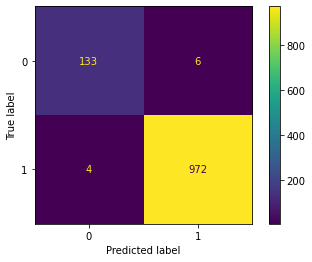

In [ ]:
plot_confusion_matrix(grid,X_test_tfidf,y_test)

In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(10,20), (10,10), (10,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
}
grid_mlp = GridSearchCV(MLPClassifier(), parameter_space, refit = True, verbose = 3)
grid_mlp.fit(X_train_tfidf,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.953 total time=  13.9s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.947 total time=  15.3s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.963 total time=  14.9s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.962 total time=  15.4s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.942 total time=  16.0s
[CV 1/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=adam;, score=0.973 total time=   4.8s
[CV 2/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=adam;, score=0.985 total time=   4.9s
[CV 3/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=adam;, score=0.979 total time=   5.2s
[CV 4/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=adam;, score=0.984 total time=   6.4s
[CV 5/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=adam;, score=0.989 total time=   4.4s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.950 total time=  15.8s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.946 total time=  16.1s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.965 total time=  16.5s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.963 total time=  13.7s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.962 total time=  13.5s
[CV 1/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=adam;, score=0.973 total time=   5.6s
[CV 2/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=adam;, score=0.984 total time=   5.1s
[CV 3/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=adam;, score=0.979 total time=   4.8s
[CV 4/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=adam;, score=0.985 total time=   5.7s
[CV 5/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=adam;, score=0.988 total time=   5.0s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, hidden_layer_sizes=(10,), solver=sgd;, score=0.929 total time=  12.6s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, hidden_layer_sizes=(10,), solver=sgd;, score=0.879 total time=  11.8s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, hidden_layer_sizes=(10,), solver=sgd;, score=0.925 total time=  13.5s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, hidden_layer_sizes=(10,), solver=sgd;, score=0.933 total time=  13.8s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, hidden_layer_sizes=(10,), solver=sgd;, score=0.915 total time=  12.1s
[CV 1/5] END activation=tanh, hidden_layer_sizes=(10,), solver=adam;, score=0.974 total time=   7.1s
[CV 2/5] END activation=tanh, hidden_layer_sizes=(10,), solver=adam;, score=0.983 total time=   7.2s
[CV 3/5] END activation=tanh, hidden_layer_sizes=(10,), solver=adam;, score=0.981 total time=   8.6s
[CV 4/5] END activation=tanh, hidden_layer_sizes=(10,), solver=adam;, score=0.985 total time=   8.1s
[CV 5/5] END activation=tanh, hidden_layer_sizes=(10,), solver=adam;, score=0.987 total time=   7.7s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.952 total time=  12.8s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.936 total time=  15.4s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.864 total time=  14.5s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.929 total time=  14.5s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.863 total time=  14.6s
[CV 1/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=adam;, score=0.973 total time=   5.6s
[CV 2/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=adam;, score=0.988 total time=   4.6s
[CV 3/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=adam;, score=0.981 total time=   4.9s
[CV 4/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=adam;, score=0.983 total time=   4.8s
[CV 5/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=adam;, score=0.989 total time=   5.0s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.948 total time=  13.4s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.862 total time=  14.9s
[CV 3/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.864 total time=   7.3s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.935 total time=  15.6s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.863 total time=  14.5s
[CV 1/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=adam;, score=0.973 total time=   7.1s
[CV 2/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=adam;, score=0.989 total time=   5.9s
[CV 3/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=adam;, score=0.982 total time=   4.3s
[CV 4/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=adam;, score=0.987 total time=   6.4s
[CV 5/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=adam;, score=0.987 total time=   4.9s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, hidden_layer_sizes=(10,), solver=sgd;, score=0.863 total time=  11.5s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, hidden_layer_sizes=(10,), solver=sgd;, score=0.876 total time=  11.7s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, hidden_layer_sizes=(10,), solver=sgd;, score=0.864 total time=  11.7s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, hidden_layer_sizes=(10,), solver=sgd;, score=0.864 total time=  11.5s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, hidden_layer_sizes=(10,), solver=sgd;, score=0.863 total time=  11.7s
[CV 1/5] END activation=relu, hidden_layer_sizes=(10,), solver=adam;, score=0.974 total time=   6.6s
[CV 2/5] END activation=relu, hidden_layer_sizes=(10,), solver=adam;, score=0.990 total time=   7.2s
[CV 3/5] END activation=relu, hidden_layer_sizes=(10,), solver=adam;, score=0.985 total time=   7.2s
[CV 4/5] END activation=relu, hidden_layer_sizes=(10,), solver=adam;, score=0.988 total time=   8.0s
[CV 5/5] END activation=relu, hidden_layer_sizes=(10,), solver=adam;, score=0.988 total time=   6.6s


GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(10, 20), (10, 10), (10,)],
                         'solver': ['sgd', 'adam']},
             verbose=3)

In [ ]:
grid_mlp.best_params_

{'activation': 'relu', 'hidden_layer_sizes': (10,), 'solver': 'adam'}

In [ ]:
grid_mlp.best_estimator_

MLPClassifier(hidden_layer_sizes=(10,))

In [ ]:
cv_results_mlp = pd.DataFrame(grid_mlp.cv_results_)[['params','mean_test_score']]

In [ ]:
def change_field_names(x):
    params = {}
    params['a'] = x['activation']
    params['hls'] = x['hidden_layer_sizes']
    params['solver'] = x['solver']
    return params

In [ ]:
cv_results_mlp['parameters'] = cv_results_mlp['params'].apply(change_field_names)

In [ ]:
cv_results_mlp[['parameters','mean_test_score']].sort_values(by='mean_test_score',ascending=False)

,parameters,mean_test_score
11,"{'a': 'relu', 'hls': (10,), 'solver': 'adam'}",0.984969
9,"{'a': 'relu', 'hls': (10, 10), 'solver': 'adam'}",0.983398
7,"{'a': 'relu', 'hls': (10, 20), 'solver': 'adam'}",0.982725
5,"{'a': 'tanh', 'hls': (10,), 'solver': 'adam'}",0.982052
1,"{'a': 'tanh', 'hls': (10, 20), 'solver': 'adam'}",0.982052
3,"{'a': 'tanh', 'hls': (10, 10), 'solver': 'adam'}",0.981828
2,"{'a': 'tanh', 'hls': (10, 10), 'solver': 'sgd'}",0.957150
0,"{'a': 'tanh', 'hls': (10, 20), 'solver': 'sgd'}",0.953333
4,"{'a': 'tanh', 'hls': (10,), 'solver': 'sgd'}",0.916092
6,"{'a': 'relu', 'hls': (10, 20), 'solver': 'sgd'}",0.908892


In [ ]:
mlp_predicted = grid_mlp.predict(X_test_tfidf)

In [ ]:
accuracy_score(y_test,mlp_predicted)

0.9928251121076234

In [ ]:
f1_score(y_test,mlp_predicted,pos_label=0)

0.9703703703703704

In [ ]:
precision_score(y_test,mlp_predicted,pos_label=0)

1.0

In [ ]:
recall_score(y_test,mlp_predicted,pos_label=0)

0.9424460431654677

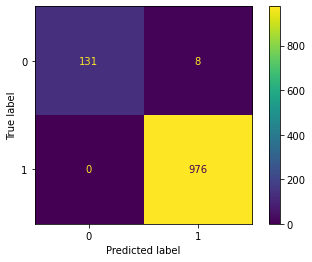

In [ ]:
plot_confusion_matrix(grid_mlp,X_test_tfidf,y_test)

In [ ]:
k_range = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
param_grid = dict(n_neighbors=k_range)

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose = 3)
grid_knn.fit(X_train_tfidf,y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END .....................n_neighbors=3;, score=0.924 total time=   0.4s
[CV 2/5] END .....................n_neighbors=3;, score=0.928 total time=   0.3s
[CV 3/5] END .....................n_neighbors=3;, score=0.951 total time=   0.3s
[CV 4/5] END .....................n_neighbors=3;, score=0.925 total time=   0.3s
[CV 5/5] END .....................n_neighbors=3;, score=0.929 total time=   0.3s
[CV 1/5] END .....................n_neighbors=5;, score=0.923 total time=   0.3s
[CV 2/5] END .....................n_neighbors=5;, score=0.918 total time=   0.3s
[CV 3/5] END .....................n_neighbors=5;, score=0.937 total time=   0.3s
[CV 4/5] END .....................n_neighbors=5;, score=0.953 total time=   0.3s
[CV 5/5] END .....................n_neighbors=5;, score=0.924 total time=   0.3s
[CV 1/5] END .....................n_neighbors=7;, score=0.909 total time=   0.3s
[CV 2/5] END .....................n_neighbors=7;

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25, 27, 29]},
             verbose=3)

In [ ]:
grid_knn.best_params_

{'n_neighbors': 15}

In [ ]:
grid_knn.best_estimator_

KNeighborsClassifier(n_neighbors=15)

In [ ]:
cv_results_knn = pd.DataFrame(grid_knn.cv_results_)[['params','mean_test_score']]

In [ ]:
cv_results_knn.sort_values(by='mean_test_score',ascending=False)

,params,mean_test_score
6,{'n_neighbors': 15},0.978461
7,{'n_neighbors': 17},0.977339
8,{'n_neighbors': 19},0.976217
9,{'n_neighbors': 21},0.975992
5,{'n_neighbors': 13},0.975322
10,{'n_neighbors': 23},0.974871
13,{'n_neighbors': 29},0.973077
11,{'n_neighbors': 25},0.973076
12,{'n_neighbors': 27},0.972852
4,{'n_neighbors': 11},0.967473


In [ ]:
knn_predicted = grid_knn.predict(X_test_tfidf)

In [ ]:
accuracy_score(y_test,knn_predicted)

0.9802690582959641

In [ ]:
f1_score(y_test,knn_predicted, pos_label=0)

0.9191176470588236

In [ ]:
precision_score(y_test,knn_predicted, pos_label=0)

0.9398496240601504

In [ ]:
recall_score(y_test,knn_predicted, pos_label=0)

0.8992805755395683

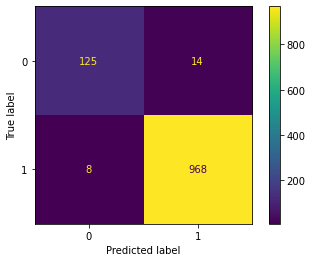

In [ ]:
plot_confusion_matrix(grid_knn,X_test_tfidf,y_test)

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01]}
 
grid_svm_w2v = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, refit = True, verbose = 3)
grid_svm_w2v.fit(X_train_w2v,y_train_w2v)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.863 total time=   2.9s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.863 total time=   2.7s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.864 total time=   2.6s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.864 total time=   2.0s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.863 total time=   2.0s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.863 total time=   2.4s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.863 total time=   2.2s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.864 total time=   1.8s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.864 total time=   1.8s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.863 total time=   1.8s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.914 total time=   0.8s
[CV 2/5] END .................C=0.1, gamma=0.01;

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01]},
             verbose=3)

In [ ]:
grid_svm_w2v.best_params_

{'C': 10, 'gamma': 0.01}

In [ ]:
grid_svm_w2v.best_estimator_

SVC(C=10, gamma=0.01)

In [ ]:
cv_results_svm_w2v = pd.DataFrame(grid_svm_w2v.cv_results_)[['params','mean_test_score']]
cv_results_svm_w2v.sort_values(by='mean_test_score',ascending=False)

,params,mean_test_score
8,"{'C': 10, 'gamma': 0.01}",0.980033
11,"{'C': 100, 'gamma': 0.01}",0.980033
5,"{'C': 1, 'gamma': 0.01}",0.978911
2,"{'C': 0.1, 'gamma': 0.01}",0.922821
7,"{'C': 10, 'gamma': 0.1}",0.909806
10,"{'C': 100, 'gamma': 0.1}",0.909806
4,"{'C': 1, 'gamma': 0.1}",0.906216
3,"{'C': 1, 'gamma': 1}",0.903076
6,"{'C': 10, 'gamma': 1}",0.903076
9,"{'C': 100, 'gamma': 1}",0.903076


In [ ]:
svm_predicted_w2v = grid_svm_w2v.predict(X_test_w2v)

In [ ]:
accuracy_score(y_test,svm_predicted_w2v)

0.989237668161435

In [ ]:
f1_score(y_test,svm_predicted_w2v, pos_label=0)

0.9558823529411764

In [ ]:
precision_score(y_test,svm_predicted_w2v, pos_label=0)

0.9774436090225563

In [ ]:
recall_score(y_test,svm_predicted_w2v, pos_label=0)

0.935251798561151

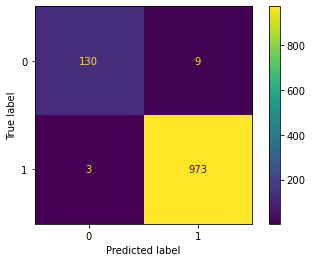

In [ ]:
plot_confusion_matrix(grid_svm_w2v, X_test_w2v, y_test_w2v)

In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(10,20), (10,10), (10,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
}
grid_mlp_w2v = GridSearchCV(MLPClassifier(), parameter_space, refit = True, verbose = 3)
grid_mlp_w2v.fit(X_train_w2v,y_train_w2v)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.980 total time=   2.0s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.985 total time=   2.0s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.984 total time=   2.1s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.985 total time=   2.2s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.987 total time=   2.1s
[CV 1/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=adam;, score=0.979 total time=   1.2s
[CV 2/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=adam;, score=0.988 total time=   1.2s
[CV 3/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=adam;, score=0.981 total time=   1.7s
[CV 4/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=adam;, score=0.981 total time=   1.5s
[CV 5/5] END activation=tanh, hidden_layer_sizes=(10, 20), solver=adam;, score=0.988 total time=   1.5s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.981 total time=   2.4s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.983 total time=   2.0s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.978 total time=   2.4s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.980 total time=   2.1s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.989 total time=   2.0s
[CV 1/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=adam;, score=0.982 total time=   1.2s
[CV 2/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=adam;, score=0.987 total time=   1.6s
[CV 3/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=adam;, score=0.981 total time=   1.0s
[CV 4/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=adam;, score=0.982 total time=   1.4s
[CV 5/5] END activation=tanh, hidden_layer_sizes=(10, 10), solver=adam;, score=0.988 total time=   1.2s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, hidden_layer_sizes=(10,), solver=sgd;, score=0.978 total time=   1.6s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, hidden_layer_sizes=(10,), solver=sgd;, score=0.984 total time=   1.7s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, hidden_layer_sizes=(10,), solver=sgd;, score=0.981 total time=   1.7s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, hidden_layer_sizes=(10,), solver=sgd;, score=0.981 total time=   1.7s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, hidden_layer_sizes=(10,), solver=sgd;, score=0.985 total time=   1.6s
[CV 1/5] END activation=tanh, hidden_layer_sizes=(10,), solver=adam;, score=0.980 total time=   1.4s
[CV 2/5] END activation=tanh, hidden_layer_sizes=(10,), solver=adam;, score=0.989 total time=   1.7s
[CV 3/5] END activation=tanh, hidden_layer_sizes=(10,), solver=adam;, score=0.983 total time=   1.5s
[CV 4/5] END activation=tanh, hidden_layer_sizes=(10,), solver=adam;, score=0.983 total time=   1.4s
[CV 5/5] END activation=tanh, hidden_layer_sizes=(10,), solver=adam;, score=0.989 total time=   1.6s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.978 total time=   2.1s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.988 total time=   2.2s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.980 total time=   2.1s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.983 total time=   2.0s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=sgd;, score=0.987 total time=   2.1s
[CV 1/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=adam;, score=0.982 total time=   1.1s
[CV 2/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=adam;, score=0.985 total time=   0.9s
[CV 3/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=adam;, score=0.982 total time=   1.0s
[CV 4/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=adam;, score=0.982 total time=   1.1s
[CV 5/5] END activation=relu, hidden_layer_sizes=(10, 20), solver=adam;, score=0.988 total time=   1.2s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.980 total time=   2.0s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.983 total time=   2.0s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.980 total time=   2.0s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.984 total time=   2.0s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=sgd;, score=0.988 total time=   2.1s
[CV 1/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=adam;, score=0.978 total time=   1.6s
[CV 2/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=adam;, score=0.984 total time=   1.0s
[CV 3/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=adam;, score=0.982 total time=   1.0s
[CV 4/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=adam;, score=0.980 total time=   1.1s
[CV 5/5] END activation=relu, hidden_layer_sizes=(10, 10), solver=adam;, score=0.989 total time=   1.5s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, hidden_layer_sizes=(10,), solver=sgd;, score=0.978 total time=   1.6s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, hidden_layer_sizes=(10,), solver=sgd;, score=0.988 total time=   1.7s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, hidden_layer_sizes=(10,), solver=sgd;, score=0.976 total time=   1.9s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, hidden_layer_sizes=(10,), solver=sgd;, score=0.985 total time=   2.1s


/Users/danilojanjusevic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, hidden_layer_sizes=(10,), solver=sgd;, score=0.984 total time=   1.9s
[CV 1/5] END activation=relu, hidden_layer_sizes=(10,), solver=adam;, score=0.982 total time=   1.2s
[CV 2/5] END activation=relu, hidden_layer_sizes=(10,), solver=adam;, score=0.984 total time=   1.7s
[CV 3/5] END activation=relu, hidden_layer_sizes=(10,), solver=adam;, score=0.978 total time=   1.4s
[CV 4/5] END activation=relu, hidden_layer_sizes=(10,), solver=adam;, score=0.976 total time=   1.5s
[CV 5/5] END activation=relu, hidden_layer_sizes=(10,), solver=adam;, score=0.987 total time=   1.7s


GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(10, 20), (10, 10), (10,)],
                         'solver': ['sgd', 'adam']},
             verbose=3)

In [ ]:
grid_mlp_w2v.best_estimator_

MLPClassifier(activation='tanh', hidden_layer_sizes=(10,))

In [ ]:
grid_mlp_w2v.best_params_

{'activation': 'tanh', 'hidden_layer_sizes': (10,), 'solver': 'adam'}

In [ ]:
cv_results_mlp_w2v = pd.DataFrame(grid_mlp_w2v.cv_results_)[['params','mean_test_score']]
cv_results_mlp_w2v['parameters'] = cv_results_mlp_w2v['params'].apply(change_field_names)
cv_results_mlp_w2v[['parameters','mean_test_score']].sort_values(by='mean_test_score',ascending=False)

,parameters,mean_test_score
5,"{'a': 'tanh', 'hls': (10,), 'solver': 'adam'}",0.984743
0,"{'a': 'tanh', 'hls': (10, 20), 'solver': 'sgd'}",0.984295
7,"{'a': 'relu', 'hls': (10, 20), 'solver': 'adam'}",0.983846
3,"{'a': 'tanh', 'hls': (10, 10), 'solver': 'adam'}",0.983845
1,"{'a': 'tanh', 'hls': (10, 20), 'solver': 'adam'}",0.983173
8,"{'a': 'relu', 'hls': (10, 10), 'solver': 'sgd'}",0.982949
6,"{'a': 'relu', 'hls': (10, 20), 'solver': 'sgd'}",0.982948
9,"{'a': 'relu', 'hls': (10, 10), 'solver': 'adam'}",0.982500
10,"{'a': 'relu', 'hls': (10,), 'solver': 'sgd'}",0.982275
2,"{'a': 'tanh', 'hls': (10, 10), 'solver': 'sgd'}",0.982051


In [ ]:

cv_results_mlp_w2v.sort_values(by='mean_test_score',ascending=False)

,params,mean_test_score,parameters
5,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.984743,"{'a': 'tanh', 'hls': (10,), 'solver': 'adam'}"
0,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.984295,"{'a': 'tanh', 'hls': (10, 20), 'solver': 'sgd'}"
7,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.983846,"{'a': 'relu', 'hls': (10, 20), 'solver': 'adam'}"
3,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.983845,"{'a': 'tanh', 'hls': (10, 10), 'solver': 'adam'}"
1,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.983173,"{'a': 'tanh', 'hls': (10, 20), 'solver': 'adam'}"
8,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.982949,"{'a': 'relu', 'hls': (10, 10), 'solver': 'sgd'}"
6,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.982948,"{'a': 'relu', 'hls': (10, 20), 'solver': 'sgd'}"
9,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.982500,"{'a': 'relu', 'hls': (10, 10), 'solver': 'adam'}"
10,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.982275,"{'a': 'relu', 'hls': (10,), 'solver': 'sgd'}"
2,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.982051,"{'a': 'tanh', 'hls': (10, 10), 'solver': 'sgd'}"


In [ ]:
predicted_mlp_w2v = grid_mlp_w2v.predict(X_test_w2v)

In [ ]:
accuracy_score(y_test,predicted_mlp_w2v)

0.9883408071748879

In [ ]:
f1_score(y_test,predicted_mlp_w2v, pos_label=0)

0.9530685920577617

In [ ]:
precision_score(y_test,predicted_mlp_w2v, pos_label=0)

0.9565217391304348

In [ ]:
recall_score(y_test,predicted_mlp_w2v, pos_label=0)

0.9496402877697842

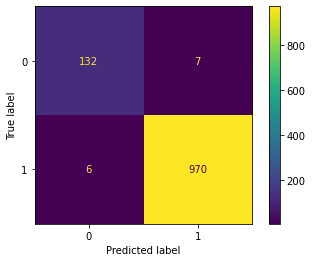

In [ ]:
plot_confusion_matrix(grid_mlp_w2v, X_test_w2v, y_test_w2v)

In [ ]:
k_range = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
param_grid = dict(n_neighbors=k_range)

grid_knn_w2v = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose = 3)
grid_knn_w2v.fit(X_train_w2v,y_train_w2v)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END .....................n_neighbors=3;, score=0.962 total time=   0.1s
[CV 2/5] END .....................n_neighbors=3;, score=0.966 total time=   0.1s
[CV 3/5] END .....................n_neighbors=3;, score=0.973 total time=   0.1s
[CV 4/5] END .....................n_neighbors=3;, score=0.975 total time=   0.1s
[CV 5/5] END .....................n_neighbors=3;, score=0.972 total time=   0.1s
[CV 1/5] END .....................n_neighbors=5;, score=0.959 total time=   0.1s
[CV 2/5] END .....................n_neighbors=5;, score=0.963 total time=   0.1s
[CV 3/5] END .....................n_neighbors=5;, score=0.972 total time=   0.1s
[CV 4/5] END .....................n_neighbors=5;, score=0.969 total time=   0.1s
[CV 5/5] END .....................n_neighbors=5;, score=0.965 total time=   0.1s
[CV 1/5] END .....................n_neighbors=7;, score=0.956 total time=   0.1s
[CV 2/5] END .....................n_neighbors=7;

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25, 27, 29]},
             verbose=3)

In [ ]:
grid_knn_w2v.best_estimator_

KNeighborsClassifier(n_neighbors=3)

In [ ]:
grid_knn_w2v.best_params_

{'n_neighbors': 3}

In [ ]:
cv_results_knn_w2v = pd.DataFrame(grid_knn_w2v.cv_results_)[['params','mean_test_score']]
cv_results_knn_w2v.sort_values(by='mean_test_score',ascending=False)

,params,mean_test_score
0,{'n_neighbors': 3},0.969713
1,{'n_neighbors': 5},0.965450
2,{'n_neighbors': 7},0.962759
3,{'n_neighbors': 9},0.959843
4,{'n_neighbors': 11},0.957823
5,{'n_neighbors': 13},0.955355
6,{'n_neighbors': 15},0.953112
7,{'n_neighbors': 17},0.950869
8,{'n_neighbors': 19},0.948400
9,{'n_neighbors': 21},0.947054


In [ ]:
predicted_knn_w2v = grid_knn_w2v.predict(X_test_w2v)

In [ ]:
accuracy_score(y_test,predicted_knn_w2v)

0.9739910313901345

In [ ]:
f1_score(y_test,predicted_knn_w2v, pos_label=0)

0.88715953307393

In [ ]:
precision_score(y_test,predicted_knn_w2v, pos_label=0)

0.9661016949152542

In [ ]:
recall_score(y_test,predicted_knn_w2v, pos_label=0)

0.8201438848920863

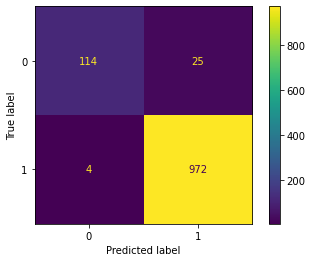

In [ ]:
plot_confusion_matrix(grid_knn_w2v, X_test_w2v, y_test_w2v)

In [ ]:
X_train_tfidf.shape

(4457, 5711)

In [ ]:
X_train_w2v.shape

(4457, 300)

kNN: ROC AUC=0.989


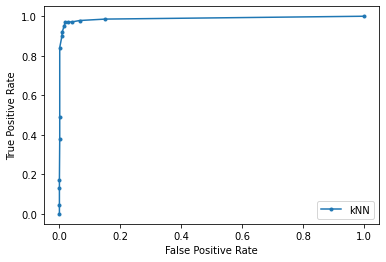

In [ ]:
knn_auc = roc_auc_score(y_test, grid_knn.predict_proba(X_test_tfidf)[:,1])
# summarize scores
print('kNN: ROC AUC=%.3f' % (knn_auc))
# calculate roc curves
knn_fpr, knn_tpr, _ = roc_curve(y_test, grid_knn.predict_proba(X_test_tfidf)[:,0], pos_label=0)
# plot the roc curve for the model
plt.plot(knn_fpr, knn_tpr, marker='.', label='kNN')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

MLP: ROC AUC=0.990


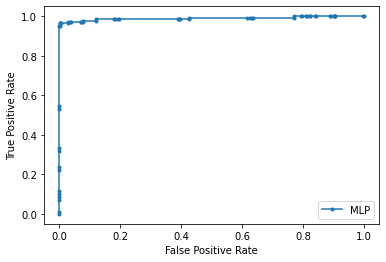

In [ ]:
mlp_auc = roc_auc_score(y_test, grid_mlp.predict_proba(X_test_tfidf)[:,1])
# summarize scores
print('MLP: ROC AUC=%.3f' % (mlp_auc))
# calculate roc curves
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, grid_mlp.predict_proba(X_test_tfidf)[:,0], pos_label=0)
# plot the roc curve for the model
plt.plot(mlp_fpr, mlp_tpr, marker='.', label='MLP')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

kNN with W2V: ROC AUC=0.954


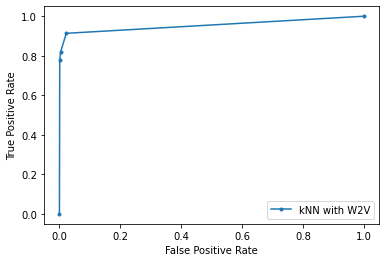

In [ ]:
knn_w2v_auc = roc_auc_score(y_test, grid_knn_w2v.predict_proba(X_test_w2v)[:,1])
# summarize scores
print('kNN with W2V: ROC AUC=%.3f' % (knn_w2v_auc))
# calculate roc curves
knn_fpr_w2v, knn_tpr_w2v, _ = roc_curve(y_test, grid_knn_w2v.predict_proba(X_test_w2v)[:,0], pos_label=0)
# plot the roc curve for the model
plt.plot(knn_fpr_w2v, knn_tpr_w2v, marker='.', label='kNN with W2V')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

MLP with W2V: ROC AUC=0.983


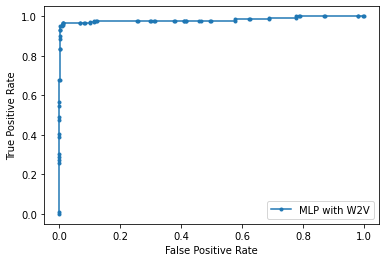

In [ ]:
mlp_w2v_auc = roc_auc_score(y_test, grid_mlp_w2v.predict_proba(X_test_w2v)[:,1])
# summarize scores
print('MLP with W2V: ROC AUC=%.3f' % (mlp_w2v_auc))
# calculate roc curves
mlp_fpr_w2v, mlp_tpr_w2v, _ = roc_curve(y_test, grid_mlp_w2v.predict_proba(X_test_w2v)[:,0], pos_label=0)
# plot the roc curve for the model
plt.plot(mlp_fpr_w2v, mlp_tpr_w2v, marker='.', label='MLP with W2V')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
scores = grid.decision_function(X_test_tfidf)

In [ ]:
scores

array([1.1092957 , 1.2650822 , 0.80666455, ..., 0.58383483, 1.60027457,
       2.04684251])

In [ ]:
thresholds = np.linspace(-3,3, 25)

For threshold -3.0 we have TPR of 0.0 and FPR of 0.0
For threshold -2.75 we have TPR of 0.0 and FPR of 0.0
For threshold -2.5 we have TPR of 0.007194244604316547 and FPR of 0.0
For threshold -2.25 we have TPR of 0.06474820143884892 and FPR of 0.0
For threshold -2.0 we have TPR of 0.14388489208633093 and FPR of 0.0
For threshold -1.75 we have TPR of 0.2733812949640288 and FPR of 0.0
For threshold -1.5 we have TPR of 0.381294964028777 and FPR of 0.0
For threshold -1.25 we have TPR of 0.5539568345323741 and FPR of 0.0
For threshold -1.0 we have TPR of 0.762589928057554 and FPR of 0.0
For threshold -0.75 we have TPR of 0.8776978417266187 and FPR of 0.0
For threshold -0.5 we have TPR of 0.9064748201438849 and FPR of 0.0
For threshold -0.25 we have TPR of 0.935251798561151 and FPR of 0.0020491803278688526
For threshold 0.0 we have TPR of 0.9568345323741008 and FPR of 0.004098360655737705
For threshold 0.25 we have TPR of 0.9640287769784173 and FPR of 0.010245901639344262
For threshold 0.5 we

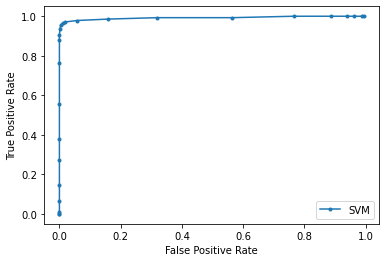

In [ ]:
svm_tpr = []
svm_fpr = []
for threshold in thresholds:
    y_hat = [0 if score<threshold else 1 for score in scores]
    svm_conf = confusion_matrix(y_test, y_hat)
    tpr = svm_conf[0,0] / (svm_conf[0,0] + svm_conf[0,1])
    fpr = svm_conf[1,0] / (svm_conf[1,0] + svm_conf[1,1])
    svm_tpr.append(tpr)
    svm_fpr.append(fpr)
    print(f'For threshold {threshold} we have TPR of {tpr} and FPR of {fpr}')
svm_tpr = np.array(svm_tpr)
svm_fpr = np.array(svm_fpr)
print('SVM: ROC AUC=%.3f' % (svm_auc))
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
svm_auc = auc(svm_fpr, svm_tpr)
print(f'AUC for SVM with TF-IDF: {svm_auc}')

AUC for SVM with TF-IDF: 0.9860427231984903


In [ ]:
mlp_auc = auc(mlp_fpr, mlp_tpr)
print(f'AUC for MLP with TF-IDF: {mlp_auc}')

AUC for MLP with TF-IDF: 0.9897835829696898


In [ ]:
knn_auc = auc(knn_fpr, knn_tpr)
print(f'AUC for KNN with TF-IDF: {knn_auc}')

AUC for KNN with TF-IDF: 0.9887921629909187


For threshold -3.0 we have TPR of 0.0 and FPR of 0.0
For threshold -2.75 we have TPR of 0.0 and FPR of 0.0
For threshold -2.5 we have TPR of 0.0 and FPR of 0.0
For threshold -2.25 we have TPR of 0.0 and FPR of 0.0
For threshold -2.0 we have TPR of 0.007194244604316547 and FPR of 0.0
For threshold -1.75 we have TPR of 0.02877697841726619 and FPR of 0.0
For threshold -1.5 we have TPR of 0.03597122302158273 and FPR of 0.0
For threshold -1.25 we have TPR of 0.20863309352517986 and FPR of 0.0
For threshold -1.0 we have TPR of 0.5179856115107914 and FPR of 0.0
For threshold -0.75 we have TPR of 0.7410071942446043 and FPR of 0.0010245901639344263
For threshold -0.5 we have TPR of 0.7841726618705036 and FPR of 0.0010245901639344263
For threshold -0.25 we have TPR of 0.8848920863309353 and FPR of 0.0010245901639344263
For threshold 0.0 we have TPR of 0.935251798561151 and FPR of 0.0030737704918032786
For threshold 0.25 we have TPR of 0.9496402877697842 and FPR of 0.005122950819672131
For thresh

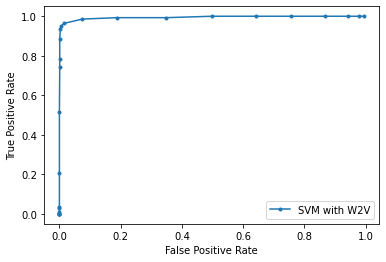

In [ ]:
svm_tpr_w2v = []
svm_fpr_w2v = []
scores_w2v = grid_svm_w2v.decision_function(X_test_w2v)
for threshold in thresholds:
    y_hat = [0 if score<threshold else 1 for score in scores_w2v]
    svm_conf = confusion_matrix(y_test, y_hat)
    tpr = svm_conf[0,0] / (svm_conf[0,0] + svm_conf[0,1])
    fpr = svm_conf[1,0] / (svm_conf[1,0] + svm_conf[1,1])
    svm_tpr_w2v.append(tpr)
    svm_fpr_w2v.append(fpr)
    print(f'For threshold {threshold} we have TPR of {tpr} and FPR of {fpr}')
svm_tpr_w2v = np.array(svm_tpr_w2v)
svm_fpr_w2v = np.array(svm_fpr_w2v)
print('SVM with W2V: ROC AUC=%.3f' % (svm_w2v_auc))
plt.plot(svm_fpr_w2v, svm_tpr_w2v, marker='.', label='SVM with W2V')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
svm_w2v_auc = auc(svm_fpr_w2v, svm_tpr_w2v)
print(f'AUC for SVM with Word2Vec: {svm_w2v_auc}')

AUC for SVM with Word2Vec: 0.9883204092463734


In [ ]:
mlp_w2v_auc = auc(mlp_fpr_w2v, mlp_tpr_w2v)
print(f'AUC for MLP with Word2Vec: {mlp_w2v_auc}')

AUC for MLP with Word2Vec: 0.9832011440028305


In [ ]:
knn_w2v_auc = auc(knn_fpr_w2v, knn_tpr_w2v)
print(f'AUC for KNN with Word2Vec: {knn_w2v_auc}')

AUC for KNN with Word2Vec: 0.9541072060384479
